In [1]:
from Bio import SeqIO
import pathlib
import pandas as pd
import seaborn as sns

In [2]:
def read_dna_data_from_file(file_path: str) -> tuple[list[str], list[int]]:
    sequences: list[str] = []
    classes: list[int] = []

    with open(file_path, 'r') as file:
        for record in SeqIO.parse(file, "fasta"):
            seq_str: str = str(record.seq)
            # The class is the last character in the sequence
            class_label: int = int(seq_str[-1])
            dna_sequence: str = seq_str[:-1]

            sequences.append(dna_sequence)
            classes.append(class_label)

    return sequences, classes

In [3]:
sequences, classes = [], []

for file_path in pathlib.Path("../data/classification").glob("*.txt"):
    file_sequences, file_classes = read_dna_data_from_file(file_path)
    
    sequences.extend(file_sequences)
    classes.extend(file_classes)

In [4]:
df = pd.DataFrame({
    "sequences": sequences,
    "classes": classes
})

In [5]:
df.head()

,sequences,classes
0,CACACCACACCCACACACCCACACACCACACCACACACCACACCAC...,0
1,TTTCTAAGTGGGATTTTTCTTAATCCTTGGATTCTTAAAAGGTTAT...,1
2,AAAGCCATTAAGGTCCAGATAACCAAGGGACAATAAACCTATGCTT...,1
3,CCATCATTTTACTTCCACATAAGTTCTAATGTTACGTAGTTCAATT...,0
4,AATTATATTTCCATCAGCTCAATACCGCAGTACTTTGAAACCTGAT...,0


In [6]:
df["sequences"].map(len).describe()

count    287367.000000
mean        499.970894
std           2.315009
min         290.000000
25%         500.000000
50%         500.000000
75%         500.000000
max         500.000000
Name: sequences, dtype: float64

In [7]:
sequences_len_diff_500 = df[df["sequences"].map(len) != 500]

In [8]:
sequences_len_diff_500.head(2)

,sequences,classes
0,CACACCACACCCACACACCCACACACCACACCACACACCACACCAC...,0
263,TTATATTTGTTTAAATTGGATTTGTTTACATTAGATTTGTTTACAT...,0


<Axes: xlabel='classes', ylabel='count'>

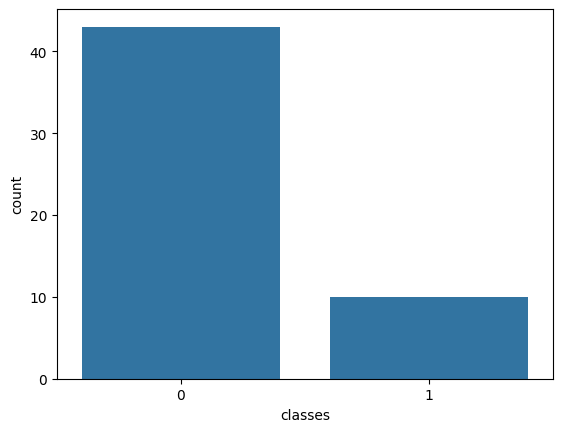

In [9]:
sns.countplot(x=sequences_len_diff_500["classes"])

We will drop the sequences with length different from 500

In [10]:
df.shape

(287367, 2)

In [11]:
len(sequences_len_diff_500.index)

53

In [12]:
df.drop(sequences_len_diff_500.index, inplace=True)

In [13]:
(df["sequences"].map(len) != 500).sum()

0

The distribution of the labels

<Axes: xlabel='classes', ylabel='count'>

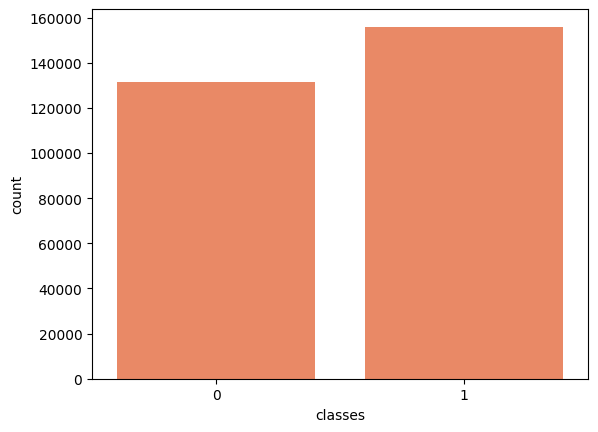

In [14]:
sns.countplot(x=df["classes"], color="coral")

In [15]:
df.to_csv("../data/classification/data.csv", index=False)